# Body Scratch - Machine Learning Intern - Assignment
#### Bianca Chiusano

### Imports

In [149]:
import tensorflow as tf
from keras import layers
import os
import numpy as np
from sklearn.model_selection import train_test_split
import pandas as pd

In [ ]:
# TODO: change the input
# TODO: change the numpy labels to be string vector

### Import Data and Labels

In [150]:
# 17 classes
class_names = ['action_down', 'action_inside', 'action_new', 'action_outside',
               'action_remove_block', 'action_select_block', 'action_switch', 
               'action_up', 'block_events_ran', 'category_control', 'category_events',
               'category_looks', 'category_motion', 'category_sound', 'dummy', 
               'select_avatar', 'select_backdrop']
class_numbers = [0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16]
base_dir = 'actions/'

In [151]:
# Initial data shape (1, 17, 64, 48) - 17 channels, size (64,48)
all_data = []
labels = []
for folder in class_names:
    folder_path = os.path.join(base_dir, folder)
    count = 0
    for file in os.listdir(folder_path):
        file_path = os.path.join(folder_path, file)

        try:
            heatmap = np.load(file_path)
            count = count +1
            all_data.append(heatmap)
            labels.append(folder)
        except Exception as e:
            print('Error loading path file')
    print(count)
print(len(all_data))
print(len(labels))

1404
2595
2000
2117
2385
2372
2974
3107
2130
2189
2088
1264
1038
2645
5963
1571
2711
40553
40553


### Csv for comfort

In [152]:
data_df = pd.DataFrame(columns=['file', 'label'])
data_df['file'] = all_data
data_df['label'] = labels
data_df.to_csv('all_data.csv')

In [153]:
import_data = pd.read_csv('all_data.csv')
import_data.head()

,Unnamed: 0,file,label
0,0,[[[[ 6.4169858e-03 1.8537384e-03 5.6571588e-...,action_down
1,1,[[[[-1.00740418e-03 7.46724603e-04 6.3997710...,action_down
2,2,[[[[ 6.18933234e-03 1.96076743e-03 1.3250164...,action_down
3,3,[[[[ 6.23758417e-03 2.78566894e-03 5.4785274...,action_down
4,4,[[[[-3.94232012e-03 1.94556662e-03 5.4315634...,action_down


### Train and Test Split

In [154]:
X_train, X_test, y_train, y_test = train_test_split(all_data, labels, test_size= 0.2, random_state=42)
train = np.vstack(X_train)
test = np.vstack(X_test)
print(train.shape)
print(test.shape)

(32442, 17, 64, 48)
(8111, 17, 64, 48)


In [160]:
train_labels = []
for label in y_train:
    if label in class_names:
        index = class_names.index(label)
        train_labels.append(class_numbers[index])

In [161]:
test_labels = []
for label in y_test:
    if label in class_names:
        index = class_names.index(label)
        test_labels.append(class_numbers[index])

In [162]:
print(y_train[0])

action_new


In [163]:
print(train_labels[0])

2


### Reshaping data labels in an appropriate shape for tensorflow

In [164]:
numpy_train = np.empty((len(y_train), 1))
for num in range(0, len(train_labels)):
    numpy_train[num] = train_labels[num]

print(numpy_train.shape)

(32442, 1)


In [165]:
numpy_test = np.empty((len(y_test), 1))
for num in range(0, len(test_labels)):
    numpy_test[num] = test_labels[num]

print(numpy_test.shape)

(8111, 1)


### Reshape for tensorflow

In [167]:
# Reshape to fit tensorflow 
reshaped_train_data = tf.transpose(train, [0, 2, 3, 1])
reshaped_test_data = tf.transpose(test, [0, 2, 3, 1])

In [168]:
# Debug
print(reshaped_train_data.shape)
print(reshaped_test_data.shape)

(32442, 64, 48, 17)
(8111, 64, 48, 17)


In [169]:
# Normalise
reshaped_train_data = reshaped_train_data / 255.0
reshaped_test_data = reshaped_test_data / 255.0

## CNN Model

#### Validation set hot encoding for train and test model

In [170]:
val_hot_encoding_train = tf.keras.utils.to_categorical(numpy_train, 17)
val_hot_encoding_test = tf.keras.utils.to_categorical(numpy_test, 17)

### Model (images)

In [177]:
model_images = tf.keras.models.Sequential()
model_images.add(layers.Conv2D(filters=32, kernel_size = (4,4), strides = (1,1), input_shape = (64,48,17), activation = 'relu'))
model_images.add(layers.MaxPooling2D(pool_size=(2,2)))
model_images.add(layers.Conv2D(filters=64, kernel_size = (4,4), activation = 'relu'))
model_images.add(layers.MaxPooling2D(pool_size=(2,2)))

model_images.add(layers.Flatten()) # into 1 dimension
model_images.add(layers.Dense(64, activation='relu'))
model_images.add(layers.Dense(32, activation='relu'))
model_images.add(layers.Dense(17, activation='softmax'))


print(model_images.summary())

Model: "sequential_24"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_24 (Conv2D)          (None, 61, 45, 32)        8736      
                                                                 
 max_pooling2d_24 (MaxPooli  (None, 30, 22, 32)        0         
 ng2D)                                                           
                                                                 
 conv2d_25 (Conv2D)          (None, 27, 19, 64)        32832     
                                                                 
 max_pooling2d_25 (MaxPooli  (None, 13, 9, 64)         0         
 ng2D)                                                           
                                                                 
 flatten_18 (Flatten)        (None, 7488)              0         
                                                                 
 dense_49 (Dense)            (None, 64)              

In [206]:
#loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
#opt = tf.keras.optimizers.legacy.Adam(learning_rate = 0.001)
#metrics = ['accuracy']
model_images.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['accuracy'])

In [207]:
hist_model_images=model_images.fit(reshaped_train_data,val_hot_encoding_train,epochs=10,validation_data=(reshaped_test_data,val_hot_encoding_test))
#hist_model_images = model_images.fit(reshaped_train_data, numpy_train, epochs=5, batch_size=32)

Epoch 1/10
1014/1014 [==============================] - 47s 46ms/step - loss: 0.8801 - accuracy: 0.7269 - val_loss: 0.0250 - val_accuracy: 0.9937
Epoch 2/10
1014/1014 [==============================] - 63s 62ms/step - loss: 0.0158 - accuracy: 0.9968 - val_loss: 0.0055 - val_accuracy: 0.9984
Epoch 3/10
1014/1014 [==============================] - 57s 56ms/step - loss: 0.0069 - accuracy: 0.9985 - val_loss: 0.0048 - val_accuracy: 0.9989
Epoch 4/10
1014/1014 [==============================] - 54s 53ms/step - loss: 0.0039 - accuracy: 0.9990 - val_loss: 0.0264 - val_accuracy: 0.9896
Epoch 5/10
1014/1014 [==============================] - 57s 56ms/step - loss: 0.0044 - accuracy: 0.9988 - val_loss: 0.0063 - val_accuracy: 0.9986
Epoch 6/10
1014/1014 [==============================] - 68s 67ms/step - loss: 0.0038 - accuracy: 0.9988 - val_loss: 8.5806e-04 - val_accuracy: 0.9999
Epoch 7/10
1014/1014 [==============================] - 68s 67ms/step - loss: 0.0017 - accuracy: 0.9995 - val_loss: 0.00

In [208]:
loss, accuracy = model_images.evaluate(reshaped_test_data, numpy_test)
print('Loss: ', loss)
print('Accuracy: ', accuracy)

254/254 [==============================] - 4s 13ms/step - loss: 6373.2896 - accuracy: 0.0361
Loss:  6373.28955078125
Accuracy:  0.03612378239631653


## Model - Keypoints

In [171]:
model_1 = tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape=(64, 48, 17)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(17, activation='softmax')
])

In [172]:
model_1.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [173]:
hist_model_1=model_1.fit(reshaped_train_data,val_hot_encoding_train,epochs=10,validation_data=(reshaped_test_data,val_hot_encoding_test))

Epoch 1/10
1014/1014 [==============================] - 20s 20ms/step - loss: 0.9420 - accuracy: 0.8149 - val_loss: 0.1147 - val_accuracy: 0.9952
Epoch 2/10
1014/1014 [==============================] - 40s 39ms/step - loss: 0.0510 - accuracy: 0.9982 - val_loss: 0.0247 - val_accuracy: 0.9988
Epoch 3/10
1014/1014 [==============================] - 46s 45ms/step - loss: 0.0150 - accuracy: 0.9994 - val_loss: 0.0103 - val_accuracy: 0.9995
Epoch 4/10
1014/1014 [==============================] - 52s 51ms/step - loss: 0.0068 - accuracy: 0.9997 - val_loss: 0.0055 - val_accuracy: 0.9995
Epoch 5/10
1014/1014 [==============================] - 55s 55ms/step - loss: 0.0036 - accuracy: 0.9998 - val_loss: 0.0033 - val_accuracy: 0.9995
Epoch 6/10
1014/1014 [==============================] - 67s 66ms/step - loss: 0.0021 - accuracy: 1.0000 - val_loss: 0.0022 - val_accuracy: 0.9995
Epoch 7/10
1014/1014 [==============================] - 140s 137ms/step - loss: 0.0013 - accuracy: 1.0000 - val_loss: 0.0015

<Axes: >

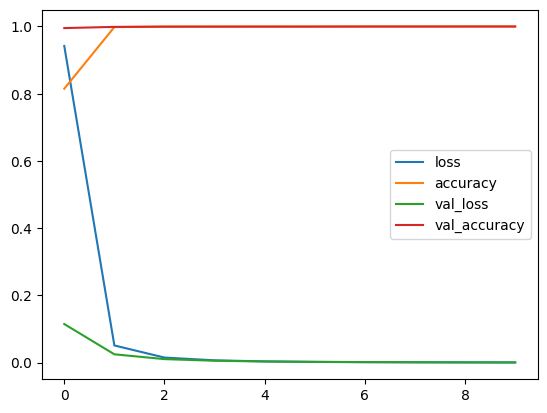

In [174]:
pd.DataFrame(hist_model_1.history).plot()

In [175]:
#Without hot encoding - 0.036 :(
evaluation = model_1.evaluate(reshaped_test_data, numpy_test)
print('Test Accuracy: {}'.format(evaluation[1]))

254/254 [==============================] - 1s 2ms/step - loss: 2185.3896 - accuracy: 0.0361
Test Accuracy: 0.03612378239631653


In [176]:
# With hot encoding - 0.99
evaluation = model_1.evaluate(reshaped_test_data, val_hot_encoding_test)
print('Test Accuracy: {}'.format(evaluation[1]))

254/254 [==============================] - 1s 2ms/step - loss: 5.9141e-04 - accuracy: 0.9999
Test Accuracy: 0.9998767375946045


## Model 2 - Keypoints with an extra Dense layer

In [210]:
model_2 = tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape=(64, 48, 17)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(17, activation='softmax')
])

model_2.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
hist_model_2 = model_2.fit(reshaped_train_data,val_hot_encoding_train,epochs=5,validation_data=(reshaped_test_data,val_hot_encoding_test))

Epoch 1/5
1014/1014 [==============================] - 23s 22ms/step - loss: 0.6817 - accuracy: 0.8379 - val_loss: 0.0375 - val_accuracy: 0.9968
Epoch 2/5
1014/1014 [==============================] - 55s 54ms/step - loss: 0.0166 - accuracy: 0.9985 - val_loss: 0.0106 - val_accuracy: 0.9988
Epoch 3/5
1014/1014 [==============================] - 41s 41ms/step - loss: 0.0051 - accuracy: 0.9997 - val_loss: 0.0048 - val_accuracy: 0.9991
Epoch 4/5
1014/1014 [==============================] - 42s 41ms/step - loss: 0.0023 - accuracy: 0.9998 - val_loss: 0.0029 - val_accuracy: 0.9995
Epoch 5/5
1014/1014 [==============================] - 33s 33ms/step - loss: 0.0012 - accuracy: 0.9999 - val_loss: 0.0018 - val_accuracy: 0.9995


In [211]:
evaluation = model_2.evaluate(reshaped_test_data, numpy_test)
print('Test Accuracy: {}'.format(evaluation[1]))

254/254 [==============================] - 1s 2ms/step - loss: 2700.3589 - accuracy: 0.0360
Test Accuracy: 0.03600049391388893


## Saving the model

In [181]:
model_1.save('model_1.h5')

/Users/biancachiusano/Documents/Coding_Projects/assignment/venv/lib/python3.11/site-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


## Importing the model and predicting a single data point

In [182]:
import_model_1 = tf.keras.models.load_model('model_1.h5')

In [201]:
single_data_point = reshaped_test_data[8]

In [200]:
actual_class = numpy_train[8]
actual_class

array([14.])

In [202]:
single_data_point = np.expand_dims(single_data_point, axis=0)

In [203]:
predictions = import_model_1.predict(single_data_point)

1/1 [==============================] - 0s 11ms/step


In [204]:
predictions

array([[4.9185434e-07, 1.1412274e-09, 6.6649923e-06, 2.5992816e-07,
        2.9107416e-10, 2.3319370e-07, 4.1049447e-10, 9.9998689e-01,
        2.8697366e-06, 1.5660976e-09, 3.8412892e-08, 2.7662611e-07,
        1.4283761e-09, 6.2770239e-10, 9.7683273e-10, 2.3764262e-06,
        3.9002849e-08]], dtype=float32)

In [205]:
predicted_class = np.argmax(predictions)
predicted_label = class_numbers[predicted_class]
print(predicted_label)

7


## Experiments

In [ ]:
# FOR IMAGES
# Learning rate
# stride
# Filter size
# pool size
# kernel size

# FOR KEYPOINTS
# Filter size
# batch size
# epochs